In [29]:
import requests
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
from datetime import datetime
import json

In [54]:
def fetch_all_reviews(app_id, language="english"):
    base_url = f"https://store.steampowered.com/appreviews/{app_id}"
    cursor = "*"
    review_chunk = []
    chunk_size = 50
    review_count = 0
    params = {
        "json": 1,
        "filter": "recent", 
        "num_per_page": 100,
        "cursor": cursor,
        "l": language, 
    }
    fetch_count = 0
    chunk_count = 0
    stop_fetching = False
    cutoff_timestamp = int(datetime(2024, 9, 1).timestamp())


    while not stop_fetching:
        params["cursor"] = cursor
        response = requests.get(base_url, params=params)
        data = response.json()

        reviews = data.get("reviews", [])
        cursor = data.get("cursor")
        
        if not reviews or not cursor:
            break
        

        review_chunk.extend(reviews)
        review_count += len(reviews)        
        fetch_count += 1
        if reviews[0]['timestamp_created'] < cutoff_timestamp:
            stop_fetching = True
        
        if fetch_count % chunk_size == 0:
            chunk_count += 1
            print(f"Batch {chunk_count} fetched {len(review_chunk)} review. cursor: {cursor}")
            json.dump(review_chunk, open(f"./data/review_{app_id}_{chunk_count}.json", "w"))
            review_chunk = []
            
    
    if review_chunk:
        chunk_count += 1
        print(f"Final batch {chunk_count} fetched {len(review_chunk)} reviews.")
        json.dump(review_chunk, open(f"./data/review_{app_id}_{chunk_count}.json", "w"))

    return review_count


# app_id = 1966720
# app_id = 1778820
app_id = 2408820
# app_id = 1174180
# app_id = 294100
# app_id = 377160
reviews = fetch_all_reviews(app_id)

Final batch 1 fetched 2269 reviews.


In [55]:
import glob

json_files = glob.glob(f"./data/review_{app_id}_*.json")

dataframes = []

for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data)
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

df

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,timestamp_dev_responded,developer_response
0,186782213,"{'steamid': '76561199383826536', 'num_games_ow...",english,Loads of fun and relaxation. Very polished pro...,1738280076,1738280076,True,0,0,0,0,True,False,False,False,NaN,NaN
1,186778446,"{'steamid': '76561199128500399', 'num_games_ow...",english,"I nice relaxing cozy game. Good graphics, and...",1738275766,1738275766,True,0,0,0,0,True,False,False,False,NaN,NaN
2,186769538,"{'steamid': '76561199799210830', 'num_games_ow...",english,"At first glance, Luma Island seems like the ki...",1738266835,1738266835,False,1,0,0.519999980926513672,0,True,False,False,True,NaN,NaN
3,186766433,"{'steamid': '76561198860334007', 'num_games_ow...",english,Visually beautiful game with high replay value...,1738263943,1738263943,True,0,0,0,0,True,False,False,False,NaN,NaN
4,186760365,"{'steamid': '76561198272551434', 'num_games_ow...",english,"Such a cute, cozy, sweet game. It has everythi...",1738258467,1738258467,True,0,1,0,0,True,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,179422629,"{'steamid': '76561198230553452', 'num_games_ow...",english,So far this game lives up to my expectations. ...,1732103914,1732103914,True,5,0,0.544549703598022461,1,True,False,False,False,NaN,NaN
2265,179421706,"{'steamid': '76561198019270479', 'num_games_ow...",english,I've been so exited for this game to finally c...,1732102508,1732102508,True,0,0,0.474938869476318359,1,True,False,False,False,NaN,NaN
2266,179421649,"{'steamid': '76561198064078023', 'num_games_ow...",english,I'm only starting and even though i've played ...,1732102421,1732365979,True,2,0,0.526132822036743164,0,True,False,False,False,NaN,NaN
2267,179420185,"{'steamid': '76561198240898662', 'num_games_ow...",english,very good cozy game with lot more then farming...,1732100201,1732100201,True,0,0,0,0,True,False,False,False,NaN,NaN


In [48]:

df['word'] = df['review'].str.split()
word_df = df.explode('word', ignore_index=True)
word_df['word'] = word_df['word'].str.lower()
word_df['word'] = word_df['word'].str.replace(r'[^a-zA-Z]+', '', regex=True)
word_df = word_df[word_df['word'] != '']
stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]
word_df = word_df[~word_df['word'].isin(stop_words)]

word_df

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,word
0,186672297,"{'steamid': '76561197970496277', 'num_games_ow...",english,"Completely open world. Go anywhere, do anythi...",1738154758,1738154758,True,0,0,0,0,True,False,False,False,completely
1,186672297,"{'steamid': '76561197970496277', 'num_games_ow...",english,"Completely open world. Go anywhere, do anythi...",1738154758,1738154758,True,0,0,0,0,True,False,False,False,open
7,186672297,"{'steamid': '76561197970496277', 'num_games_ow...",english,"Completely open world. Go anywhere, do anythi...",1738154758,1738154758,True,0,0,0,0,True,False,False,False,tremendous
8,186672297,"{'steamid': '76561197970496277', 'num_games_ow...",english,"Completely open world. Go anywhere, do anythi...",1738154758,1738154758,True,0,0,0,0,True,False,False,False,variety
9,186672297,"{'steamid': '76561197970496277', 'num_games_ow...",english,"Completely open world. Go anywhere, do anythi...",1738154758,1738154758,True,0,0,0,0,True,False,False,False,stunning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160745,173493750,"{'steamid': '76561198151986321', 'num_games_ow...",english,Legendary Game that you can always come back a...,1724728496,1724728496,True,1,0,0.523809552192687988,0,True,False,False,False,game
160753,173493750,"{'steamid': '76561198151986321', 'num_games_ow...",english,Legendary Game that you can always come back a...,1724728496,1724728496,True,1,0,0.523809552192687988,0,True,False,False,False,play
160754,173490601,"{'steamid': '76561199227061427', 'num_games_ow...",english,dont get this if you play on geforce now,1724724933,1724724933,False,0,0,0.489891141653060913,0,True,False,False,False,dont
160759,173490601,"{'steamid': '76561199227061427', 'num_games_ow...",english,dont get this if you play on geforce now,1724724933,1724724933,False,0,0,0.489891141653060913,0,True,False,False,False,play


In [58]:
grouped_df = word_df.groupby('word')['word'].count()
grouped_df


word
aaa          5
aaaaaaaa     1
aarak        1
abandon      2
abandoned    8
            ..
zomboid      1
zone         6
zones        1
zooms        1
zrh          1
Name: word, Length: 9721, dtype: int64

In [59]:
freq_df =grouped_df.sort_values(ascending=False)
freq_df = freq_df[freq_df > 10]
freq_df.to_csv('./data/word_freq.csv')

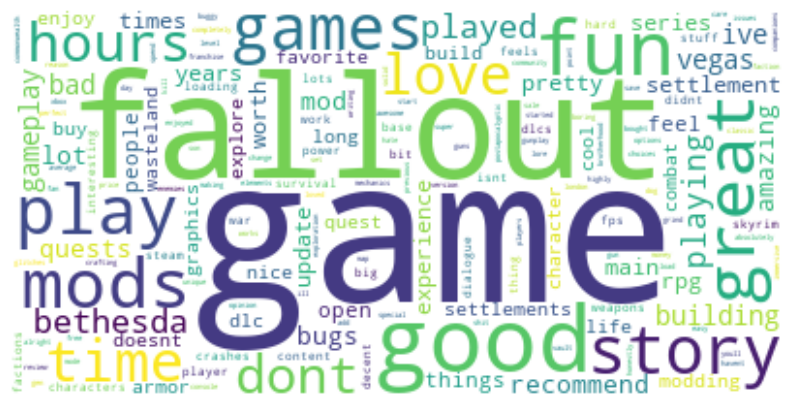

In [60]:
wordcloud_positive = WordCloud(background_color='white', max_words=500).generate_from_frequencies(freq_df)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.show()



In [61]:
df['date'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['year_month'] = df['date'].dt.to_period('M')  # 연도-월 포맷 (YYYY-MM)
monthly_review_counts = df.groupby('year_month').size()
monthly_review_counts = monthly_review_counts.reset_index(name='review_count')
monthly_review_counts

,year_month,review_count
0,2024-11,1192
1,2024-12,783
2,2025-01,294


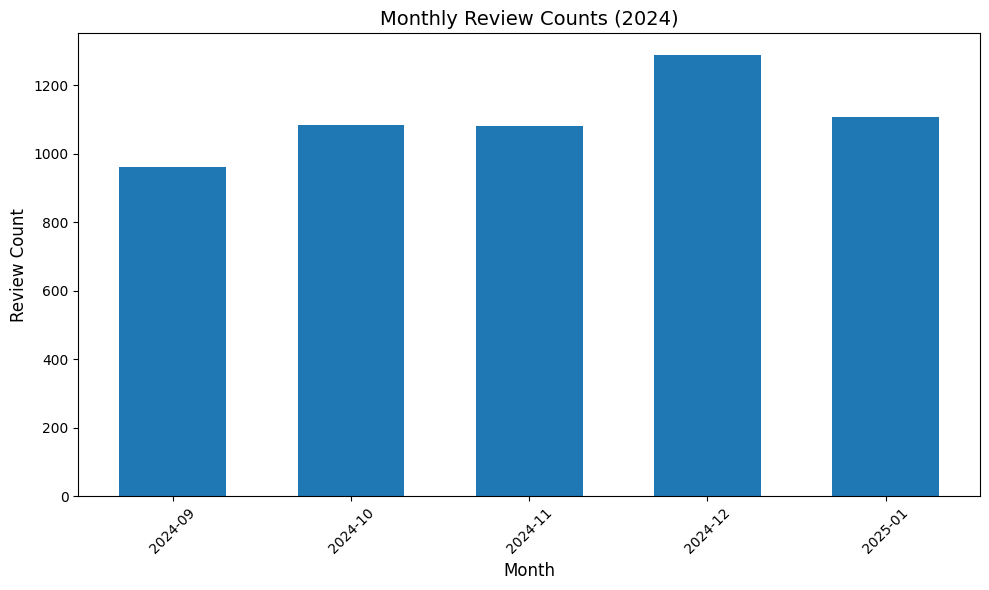

In [53]:
monthly_review_counts = monthly_review_counts.iloc[1:].reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.bar(monthly_review_counts['year_month'].astype(str), monthly_review_counts['review_count'], width=0.6)
plt.title('Monthly Review Counts (2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()